# fully-connected neural network

In [1]:
#! conda activate tf-gpu

In [2]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

2025-04-02 20:22:38.999982: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 20:22:39.006738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743639759.015181  234233 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743639759.017881  234233 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 20:22:39.026602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
%load_ext autoreload
%autoreload 2

## 1. dataset

In [4]:
infile = '/home/yuan/results/epitope/combined_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# shuffle rows
df = df.sample(frac=1)
df['label'] = df['label'].map({'epitope':1, 'other': 0, 'random':0})
print(df.shape)

(3182867, 457)


In [5]:
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_VL,has_VK,has_VM,has_VF,has_VP,has_VS,has_VT,has_VW,has_VY,has_VV
1407507,VNYTGASIL,1,39.555556,0.865556,7.633333,0.128889,2.846667,41.0,0.61,8.1,...,0,0,0,0,0,0,0,0,0,0
2285708,TNDGPDNQA,0,-18.666667,0.413333,10.377778,0.104778,2.414444,-28.0,0.07,10.5,...,0,0,0,0,0,0,0,0,0,0
114037,KAMKRSHSPTKK,1,-2.166667,0.808333,9.575000,0.168917,3.651667,-9.5,0.88,9.8,...,0,0,0,0,0,0,0,0,0,0
3153329,LPDRYTVSEEI,0,15.090909,1.000000,8.736364,0.164455,3.714545,-5.0,0.60,8.6,...,0,0,0,0,0,1,0,0,0,0
2425231,KTWKRRWFILT,0,40.181818,1.333636,7.900000,0.246909,5.186364,13.0,1.15,8.6,...,0,0,0,0,0,0,0,0,0,0


In [6]:
from collections import Counter

X = np.array(df.iloc[:,2:], dtype=np.float16)
y = np.array(df.iloc[:,1], dtype=np.float16)
print(X.shape, X.dtype, y.shape, y.dtype)
Counter(y)

(3182867, 455) float16 (3182867,) float16


Counter({np.float16(1.0): 1798795, np.float16(0.0): 1384072})

In [7]:
# normalization X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_X = scaler.fit_transform(X)

In [8]:
#split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(norm_X, y, train_size=0.8, shuffle=True, random_state=2)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size=0.7, shuffle=True, random_state=2)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(1782405, 455) (1782405,)
(763888, 455) (763888,)
(636574, 455) (636574,)


## 2. train model

In [9]:
from tensorflow.keras.layers import Input, Dense, Dropout

# input features
num_features = int(X.shape[-1])
# outccome is binary
model = tf.keras.Sequential([
    Input(shape=(num_features,)),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(96, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])
model.summary()

I0000 00:00:1743639837.922269  234233 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9163 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,817 (1.08 MB)

 Trainable params: 282,817 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# loss_fn = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    # loss=tf.keras.losses.BinaryCrossentropy,
    loss = 'BinaryCrossentropy',
    optimizer=optim,
    metrics=['accuracy', 'precision', 'recall', 'auc', 'mse']
)

epochs = 10
history= model.fit(
    X_train,
    y_train,
    validation_data=(X_validate, y_validate),
    epochs=epochs,
    verbose=True
)

res = pd.DataFrame(history.history)
print(res.head(3))
print(res.tail(3))

Epoch 1/10


I0000 00:00:1743639841.966243  234438 service.cc:148] XLA service 0x79d394005120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743639841.966260  234438 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-02 20:24:01.988453: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743639842.064701  234438 cuda_dnn.cc:529] Loaded cuDNN version 90800


   87/55701 ━━━━━━━━━━━━━━━━━━━━ 1:38 2ms/step - accuracy: 0.5603 - auc: 0.5639 - loss: 0.7866 - mse: 0.2743 - precision: 0.6023 - recall: 0.6480

I0000 00:00:1743639842.622424  234438 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55701/55701 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7215 - auc: 0.7724 - loss: 0.5642 - mse: 0.1893 - precision: 0.7162 - recall: 0.8412

E0000 00:00:1743639920.431568  234438 buffer_comparator.cc:157] Difference at 16: 1, expected 260.803
E0000 00:00:1743639920.431591  234438 buffer_comparator.cc:157] Difference at 17: 1, expected 274.951
E0000 00:00:1743639920.431593  234438 buffer_comparator.cc:157] Difference at 18: 1, expected 253.659
E0000 00:00:1743639920.431594  234438 buffer_comparator.cc:157] Difference at 19: 1, expected 257.607
E0000 00:00:1743639920.431595  234438 buffer_comparator.cc:157] Difference at 20: 1, expected 250.262
E0000 00:00:1743639920.431597  234438 buffer_comparator.cc:157] Difference at 21: 0, expected 258.782
E0000 00:00:1743639920.431598  234438 buffer_comparator.cc:157] Difference at 22: 0, expected 253.591
E0000 00:00:1743639920.431599  234438 buffer_comparator.cc:157] Difference at 23: 0, expected 258.759
E0000 00:00:1743639920.431600  234438 buffer_comparator.cc:157] Difference at 24: 1, expected 259.406
E0000 00:00:1743639920.431601  234438 buffer_comparator.cc:157] Difference at 25: 

55701/55701 ━━━━━━━━━━━━━━━━━━━━ 102s 2ms/step - accuracy: 0.7215 - auc: 0.7724 - loss: 0.5642 - mse: 0.1893 - precision: 0.7162 - recall: 0.8412 - val_accuracy: 0.7455 - val_auc: 0.8025 - val_loss: 0.5357 - val_mse: 0.1773 - val_precision: 0.7401 - val_recall: 0.8463
Epoch 2/10
55701/55701 ━━━━━━━━━━━━━━━━━━━━ 104s 2ms/step - accuracy: 0.7480 - auc: 0.8025 - loss: 0.5329 - mse: 0.1760 - precision: 0.7325 - recall: 0.8734 - val_accuracy: 0.7460 - val_auc: 0.8066 - val_loss: 0.5570 - val_mse: 0.1808 - val_precision: 0.7638 - val_recall: 0.7962
Epoch 3/10
55701/55701 ━━━━━━━━━━━━━━━━━━━━ 108s 2ms/step - accuracy: 0.7529 - auc: 0.8098 - loss: 0.5246 - mse: 0.1728 - precision: 0.7366 - recall: 0.8769 - val_accuracy: 0.7449 - val_auc: 0.8074 - val_loss: 0.5417 - val_mse: 0.1796 - val_precision: 0.7640 - val_recall: 0.7928
Epoch 4/10
55701/55701 ━━━━━━━━━━━━━━━━━━━━ 108s 2ms/step - accuracy: 0.7554 - auc: 0.8142 - loss: 0.5199 - mse: 0.1709 - precision: 0.7382 - recall: 0.8790 - val_accuracy

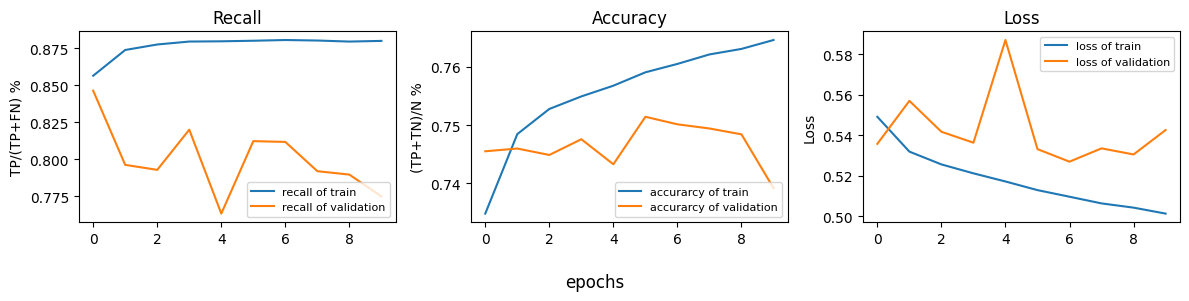

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12,3), layout='tight')
x = range(epochs)
fig.supxlabel('epochs')

i=0
axes[i].plot(x, history.history['recall'], label='recall of train')
axes[i].plot(x, history.history['val_recall'], label='recall of validation')
axes[i].set_ylabel('TP/(TP+FN) %')
axes[i].set_title('Recall')
axes[i].legend(loc='lower right', fontsize=8)

i=1
axes[i].plot(x, history.history['accuracy'], label='accurarcy of train')
axes[i].plot(x, history.history['val_accuracy'], label='accurarcy of validation')
axes[i].set_ylabel('(TP+TN)/N %')
axes[i].set_title('Accuracy')
axes[i].legend(loc='lower right', fontsize=8)

i=2
axes[i].plot(x, history.history['loss'], label='loss of train')
axes[i].plot(x, history.history['val_loss'], label='loss of validation')
axes[i].set_ylabel('Loss')
axes[i].set_title('Loss')
axes[i].legend(loc='upper right', fontsize=8)

In [12]:
eval_res = model.evaluate(X_test, y_test, return_dict=True)
print(eval_res)

19867/19893 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.7389 - auc: 0.8078 - loss: 0.5435 - mse: 0.1808 - precision: 0.7662 - recall: 0.7737

E0000 00:00:1743640924.451309  234448 buffer_comparator.cc:157] Difference at 16: 0, expected 261.95
E0000 00:00:1743640924.451342  234448 buffer_comparator.cc:157] Difference at 17: 1, expected 267.991
E0000 00:00:1743640924.451344  234448 buffer_comparator.cc:157] Difference at 18: 1, expected 268.791
E0000 00:00:1743640924.451345  234448 buffer_comparator.cc:157] Difference at 19: 1, expected 251.978
E0000 00:00:1743640924.451347  234448 buffer_comparator.cc:157] Difference at 20: 1, expected 256.71
E0000 00:00:1743640924.451348  234448 buffer_comparator.cc:157] Difference at 21: 0, expected 256.73
E0000 00:00:1743640924.451349  234448 buffer_comparator.cc:157] Difference at 22: 1, expected 259.493
E0000 00:00:1743640924.451350  234448 buffer_comparator.cc:157] Difference at 23: 1, expected 258.042
E0000 00:00:1743640924.451351  234448 buffer_comparator.cc:157] Difference at 24: 1, expected 262.804
E0000 00:00:1743640924.451352  234448 buffer_comparator.cc:157] Difference at 25: 0, 

19893/19893 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.7389 - auc: 0.8078 - loss: 0.5435 - mse: 0.1808 - precision: 0.7662 - recall: 0.7737
{'accuracy': 0.7396579384803772, 'auc': 0.8084341883659363, 'loss': 0.5428464412689209, 'mse': 0.1804674118757248, 'precision': 0.766717255115509, 'recall': 0.7746455669403076}


In [13]:
pred_test = model.predict(X_test)
pred_test[:3]

19893/19893 ━━━━━━━━━━━━━━━━━━━━ 10s 501us/step


array([[0.18815607],
       [0.745399  ],
       [0.3332566 ]], dtype=float32)

Text(0.5, 1.0, 'Prediction of non-epitopes 277118')

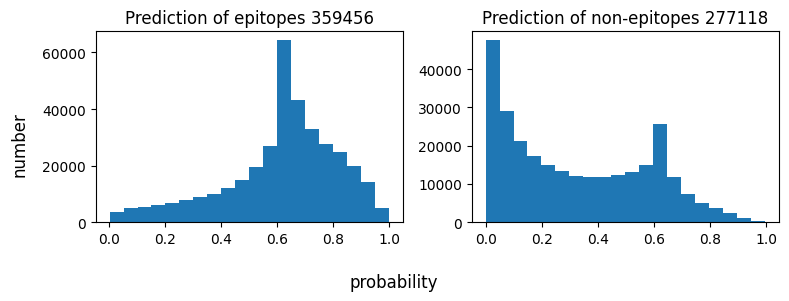

In [14]:

t = pred_test[y_test==1]
f = pred_test[y_test==0]
fig, ax = plt.subplots(1, 2, figsize=(8,3), layout='tight')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, label='True', bins=20)
ax[0].set_title(f'Prediction of epitopes {len(t)}')
ax[1].hist(f, label='False', bins=20)
ax[1].set_title(f'Prediction of non-epitopes {len(f)}')

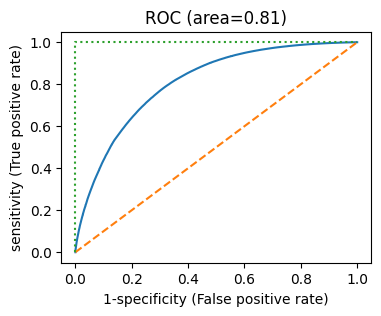

In [15]:
# ROC curve only for binary classfication
from sklearn.metrics import roc_curve, auc
# FPR, false positive rate, 1- specificity, typ I error
# TPR, true positive rate, sensitivity, power
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(fpr, tpr)
ax.set_xlabel('1-specificity (False positive rate)')
ax.set_ylabel('sensitivity (True positive rate)')
plt.title(f'ROC (area={roc_auc:.2f})')
ax.plot([0,1], [0,1], '--')
ax.plot([0,0,1], [0,1,1], ':')

In [16]:
# save entire model
model.save('../models/epitopes_ann.keras')